# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

training_variables = util.training_variables
columns = util.all_relevant_variables

In [2]:
# 4S_offres Data vs MC
columns = util.all_relevant_variables

# Load data files
MC_4S_offres = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_4Soffres_e_quaxo_2/4Soffres_quaxo.root:B0'],
                          library="np",)
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          #filter_branch=lambda branch: branch.name in columns)

data_4S_offres = uproot.concatenate([f'../../Samples/Data/e_channel/*4Soffres_e_persian_1.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

df_mc = pd.DataFrame(MC_4S_offres)
df_data = pd.DataFrame(data_4S_offres)

In [ ]:
test = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_eetautau_4S_offres_e_1/sub00/MC_e_00000_job420629657_00.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)
df_test = pd.DataFrame(test)

df_test

In [3]:
# load MVA
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../../BDTs/LightGBM/lgbm_multiclass.txt')
cut='signal_prob<0.3 and continuum_prob>0.8 and fakeD_prob<0.05'

In [4]:
for df in [df_mc,df_data]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)
#     df['D_daughter_pValue_min'] = df[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].min(axis=1)
#     df['D_daughter_pValue_mean'] = df[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].mean(axis=1)


In [5]:
pred_mc = bst_lgb.predict(df_mc[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out_mc = pd.DataFrame(pred_mc, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb_mc = pd.concat([df_mc, lgb_out_mc], axis=1)
df_lgb_mc['largest_prob'] = df_lgb_mc[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred_mc,lgb_out_mc

pred_data = bst_lgb.predict(df_data[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out_data = pd.DataFrame(pred_data, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb_data = pd.concat([df_data, lgb_out_data], axis=1)
df_lgb_data['largest_prob'] = df_lgb_data[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred_data,lgb_out_data

# Test, apply the MVA cut
df_cut_mc=df_lgb_mc.query(cut)
df_bestSelected_mc=df_cut_mc.loc[df_cut_mc.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]

df_cut_data=df_lgb_data.query(cut)
df_bestSelected_data=df_cut_data.loc[df_cut_data.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]

In [6]:
columns_without_nan = df_bestSelected_data.columns[~df_bestSelected_data.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_bestSelected_mc, 'e', template=False)
mpl=util.mpl(samples,df_bestSelected_data)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 39775
bkg_TDFl 654
bkg_fakeTracks 1110
bkg_continuum 5636
bkg_combinatorial 0
bkg_singleBbkg 0
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$ 0
$D\ell\nu$_gap 0
bkg_other_signal 0


In [16]:
def statistics(df):
    counts=df.count()
    mean=df.mean()
    std=df.std()
    return f'''{counts=:d} \n{mean=:.3f} \n{std=:.3f}'''

    
def plot_data_mc(data, mc, bins, variables=columns_without_nan, cut=None, scale=[1,1], figsize=(30, 100), fontsize=12):
    fig = plt.figure(figsize=figsize)
    dfs = [mc, data]
    names = ['MC', 'Data']
    
    for i in range(len(variables)):
        ax = fig.add_subplot(len(variables)//3 + 1, 3, i+1)
        bin1 = bins
        for j in range(len(names)):
            dfs[j]['__weight__'] = scale[j]
            var_col = dfs[j][variables[i]]
            if cut is not None:
                var_col = var_col.query(cut)
            (counts, bin1) = np.histogram(var_col, bins=bin1,
                                       weights=dfs[j].query(cut)['__weight__'] if cut else dfs[j]['__weight__'])
            kwarg={'histtype':'step','lw':2}

            ax.hist(bin1[:-1], bin1, weights=counts,
                    label=f'{names[j]} \n{statistics(var_col)} \n cut_eff={(len(var_col)/len(dfs[j])):.3f}',**kwarg)
        
        ax.set_ylabel(f'# of events per bin {(bin1[1]-bin1[0]):.3f} GeV',fontsize=fontsize)
        ax.set_xlabel(variables[i],fontsize=fontsize)
        ax.grid()
#         ax.legend()
    fig.suptitle(f'Overlaid wrongCharge at 4S Data vs MC ({cut=})', fontsize=fontsize*2)
    plt.tight_layout()

In [ ]:
plot_data_mc(data=df_bestSelected_data, mc=df_bestSelected_mc, 
             bins=30,variables=columns_without_nan,cut=None,scale=[42/50,1],
            figsize=(30, 150), fontsize=12)

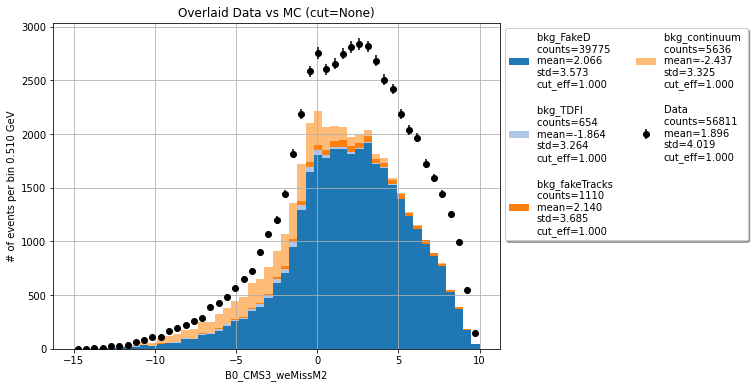

In [23]:
b1 = np.linspace(-15,10,50)
mpl.plot_data_mc_overlaid(variable='B0_CMS3_weMissM2',bins=b1,cut=None,scale=[1,42/50])

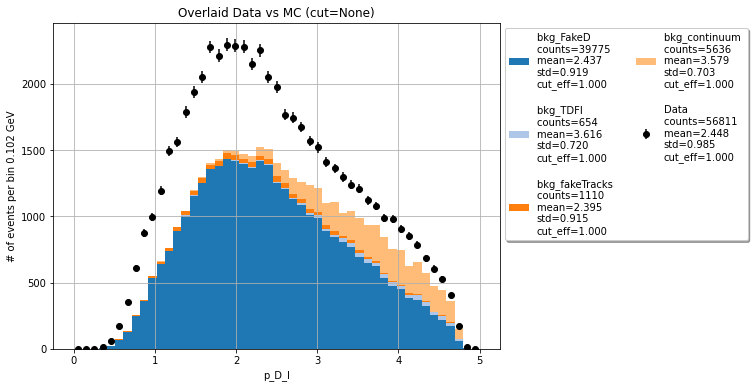

In [24]:
b1 = np.linspace(0,5,50)
mpl.plot_data_mc_overlaid(variable='p_D_l',bins=b1,cut=None,scale=[1,42/50])

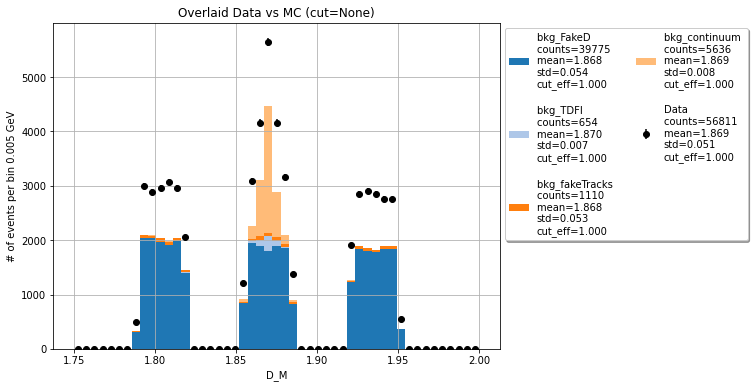

In [18]:
b1 = np.linspace(1.75,2,50)
mpl.plot_data_mc_overlaid(variable='D_M',bins=b1,cut=None,scale=[1,42/50])

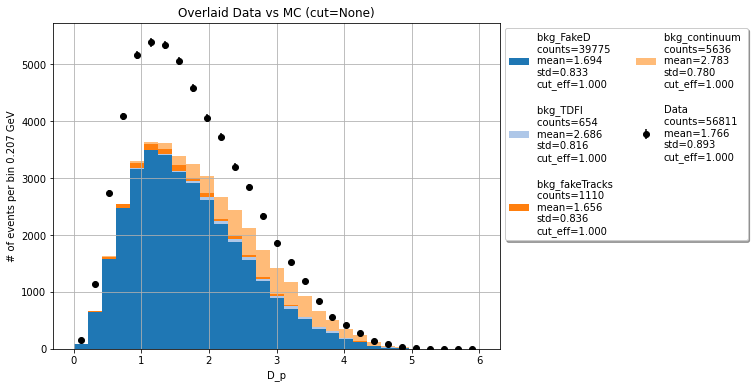

In [26]:
b1 = np.linspace(0,6,30)
mpl.plot_data_mc_overlaid(variable='D_p',bins=b1,cut=None,scale=[1,42/50])

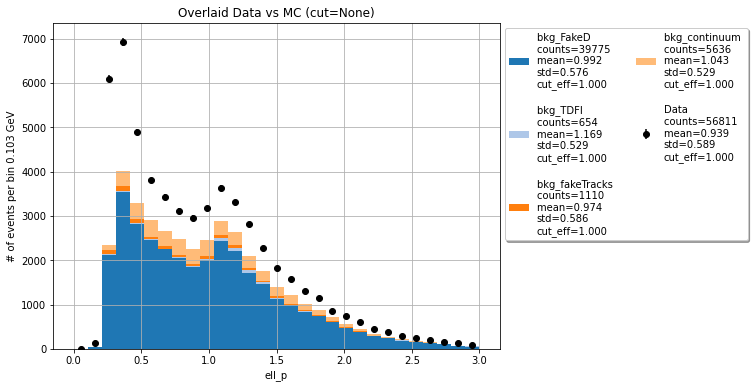

In [19]:
b1 = np.linspace(0,3,30)
mpl.plot_data_mc_overlaid(variable='ell_p',bins=b1,cut=None,scale=[1,42/50])

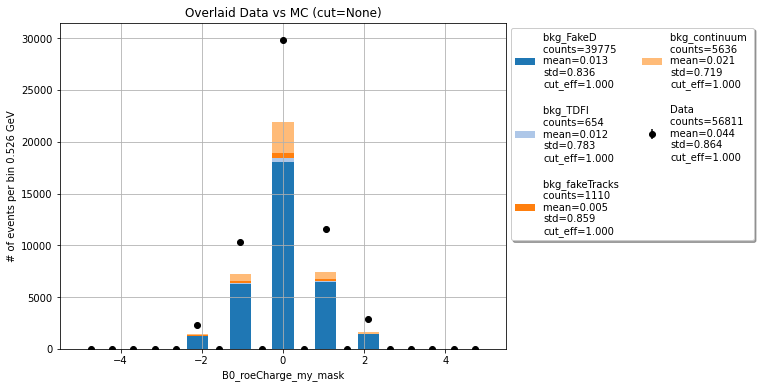

In [27]:
b1 = np.linspace(-5,5,20)
mpl.plot_data_mc_overlaid(variable='B0_roeCharge_my_mask',bins=b1,cut=None,scale=[1,42/50])

## Create continuum template

In [8]:
Dsb = df_bestSelected_mc.query('D_M<1.83 or D_M>1.9').copy()
D_sig = df_bestSelected_mc.query('1.83<D_M<1.9').copy()

# Define the fitting range and number of bins, 'p_D_l'
start = 0.5 # 0.8 before adding fakeD
end = 5
num_bins = 40

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -12 # -1.1 before adding fakeD
end = 9.5 # 8.6 before adding fakeD
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

bin_threshold = 1

In [31]:
test_histograms = {}
test_staterr = {}
for name, df in {'D_sig':D_sig,'Dsb':Dsb,'true_cont':samples['bkg_continuum']}.items():

    (counts, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                              df['p_D_l'],
                                              bins=[MM2_bins, p_D_l_bins],
                                              weights=df['__weight__'])

    (staterr_squared, xedges, yedges) = np.histogram2d(df['B0_CMS3_weMissM2'], 
                                                       df['p_D_l'],
                                                       bins=[MM2_bins, p_D_l_bins],
                                                       weights=df['__weight__']**2)
    test_histograms[name] = counts
    test_staterr[name] = np.sqrt(staterr_squared)

In [32]:
continuum_2d = test_histograms['D_sig'] - 0.5*test_histograms['Dsb']
continuum_mod = np.where(continuum_2d < 0, 0, continuum_2d)

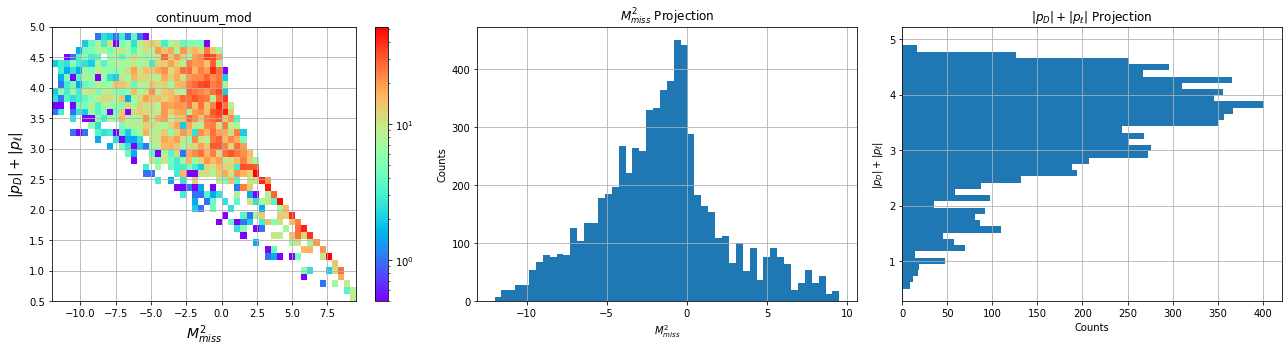

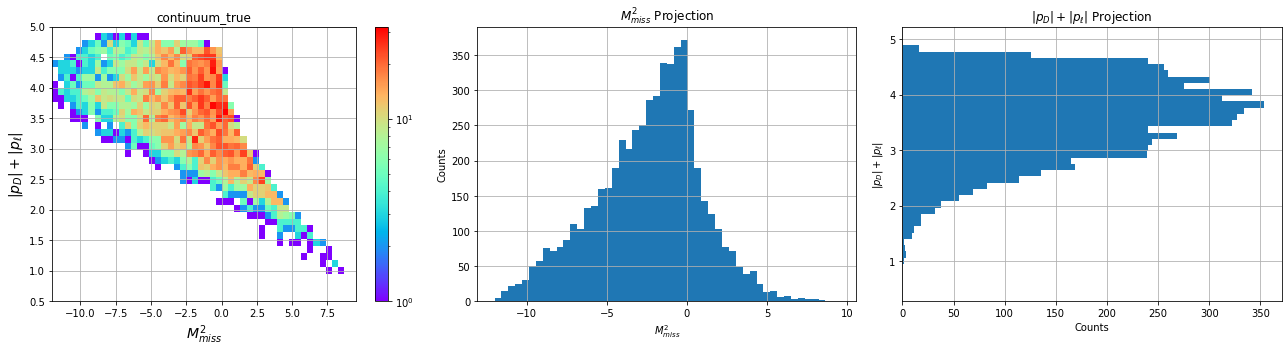

In [33]:
hists = {'continuum_mod': continuum_mod, 'continuum_true':test_histograms['true_cont']}

for name, hist in hists.items():
    # Compute projections
    x_projection = hist.sum(axis=1)  # Sum along the y-axis
    y_projection = hist.sum(axis=0)  # Sum along the x-axis

    # Plot the 2D histogram
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    # 2D Histogram
    im = ax[0].imshow(hist.T, origin='lower', aspect='auto', 
                     cmap='rainbow', norm=colors.LogNorm(),
                     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    fig.colorbar(im, ax=ax[0])
    ax[0].set_title(name)
    ax[0].set_xlabel('$M_{miss}^2$', fontsize=14)
    ax[0].set_ylabel('$|p_D| + |p_{\ell}|$', fontsize=14)
    ax[0].grid()

    # X Projection
    ax[1].bar(xedges[:-1], x_projection, width=np.diff(xedges), align='edge')
    ax[1].set_title('$M_{miss}^2$ Projection')
    ax[1].set_xlabel('$M_{miss}^2$')
    ax[1].set_ylabel('Counts')
    ax[1].grid()

    # Y Projection
    ax[2].barh(yedges[:-1], y_projection, height=np.diff(yedges), align='edge')
    ax[2].set_title('$|p_D| + |p_{\ell}|$ Projection')
    ax[2].set_xlabel('Counts')
    ax[2].set_ylabel('$|p_D| + |p_{\ell}|$')
    ax[2].grid()

    plt.tight_layout()
    plt.show()

## Lepton correction

In [7]:
efficiency_e_table = pd.read_csv('~/B2SW/2024_OleMiss/systematics_framework/correction-tables/MC15/run_independent/PID/coarse_theta_binning/efficiency/e_efficiency_table.csv')
efficiency_e_table

,phsp_bin_idx,threshold,channel,n_in_comb,chi2,pvalue,is_final_comb,is_best_available,n_duplicates,is_unique,...,data_MC_uncertainty_statsys_dn,data_MC_uncertainty_statsys_up,rel_data_MC_uncertainty_stat_dn,rel_data_MC_uncertainty_stat_up,rel_data_MC_uncertainty_sys_dn,rel_data_MC_uncertainty_sys_up,rel_data_MC_uncertainty_statsys_dn,rel_data_MC_uncertainty_statsys_up,data_MC_DISTsys_dn,data_MC_DISTsys_up
0,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.001742,0.002292,0.016717,0.016797,0.175815,0.231753,0.176608,0.232361,0.000000,0.0
1,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.009143,0.017781,0.008894,0.008949,0.911959,1.773646,0.912002,1.773669,0.000000,0.0
2,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.007895,0.000544,0.054222,0.054061,0.783194,0.000000,0.785069,0.054061,0.007877,0.0
3,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.009262,0.000276,0.027743,0.027448,0.921046,0.000000,0.921464,0.027448,0.009258,0.0
4,NaN,0.50,jpsill_VS_eell_VS_eegamma,3,NaN,NaN,True,True,0,True,...,0.000338,0.000364,0.003975,0.003997,0.033591,0.036207,0.033825,0.036427,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,208.0,0.99,eegamma,1,-1.0,-1.0,False,True,0,True,...,0.016502,0.016502,0.588662,0.588662,1.603855,1.603855,1.708471,1.708471,0.000000,0.0
3268,211.0,0.99,eegamma,1,-1.0,-1.0,False,True,0,True,...,0.095886,0.095886,0.359123,0.359123,10.429960,10.429960,10.436141,10.436141,0.000000,0.0
3269,210.0,0.99,eegamma,1,-1.0,-1.0,False,True,0,True,...,0.048495,0.048495,1.493169,1.493169,4.796632,4.796632,5.023668,5.023668,0.000000,0.0
3270,213.0,0.99,eegamma,1,-1.0,-1.0,False,True,0,True,...,0.096099,0.096099,0.359135,0.359135,10.453701,10.453701,10.459868,10.459868,0.000000,0.0


In [8]:
pi_e_fake_table = pd.read_csv('~/B2SW/2024_OleMiss/systematics_framework/correction-tables/MC15/run_independent/PID/coarse_theta_binning/fakeRate/pi_e_fakeRate_table.csv')
pi_e_fake_table

,channel,n_in_comb,is_final_comb,is_best_available,n_duplicates,is_unique,is_outlier,is_abnormal,is_sumquad,is_stat_clipped_dn,...,data_MC_uncertainty_statsys_dn,data_MC_uncertainty_statsys_up,rel_data_MC_uncertainty_stat_dn,rel_data_MC_uncertainty_stat_up,rel_data_MC_uncertainty_sys_dn,rel_data_MC_uncertainty_sys_up,rel_data_MC_uncertainty_statsys_dn,rel_data_MC_uncertainty_statsys_up,data_MC_DISTsys_dn,data_MC_DISTsys_up
0,kspipi_VS_taupair,2,True,True,0,True,False,False,True,False,...,2.630327,0.050116,0.837135,1.235267,64.827156,0.000000,64.832561,1.235267,2.630107,0.0
1,kspipi_VS_taupair,2,True,True,0,True,False,False,True,False,...,2.488109,0.034027,0.749005,0.706866,51.681067,0.000000,51.686494,0.706866,2.487848,0.0
2,kspipi_VS_taupair,2,True,True,0,True,False,False,True,False,...,0.006898,0.006874,0.440826,0.439350,0.000000,0.000000,0.440826,0.439350,0.000000,0.0
3,kspipi_VS_taupair,2,True,True,0,True,False,False,True,False,...,0.016226,0.009839,0.797070,0.483300,0.000000,0.000000,0.797070,0.483300,0.000000,0.0
4,kspipi_VS_taupair,2,True,True,0,True,False,False,True,False,...,0.316051,0.015046,0.907240,0.729483,15.296841,0.000000,15.323721,0.729483,0.315497,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459,taupair,1,False,True,0,True,False,False,True,True,...,1.992000,2.172000,100.000000,109.036145,0.000000,0.000000,100.000000,109.036145,0.000000,0.0
2460,taupair,1,False,True,0,True,False,False,True,False,...,0.423322,0.423322,53.992347,53.992347,0.549362,0.549362,53.995142,53.995142,0.000000,0.0
2461,taupair,1,False,True,0,True,False,False,True,True,...,2.584000,2.720000,100.000000,105.263158,0.000000,0.000000,100.000000,105.263158,0.000000,0.0
2462,taupair,1,False,True,0,True,False,False,True,False,...,0.380900,0.380900,78.552279,78.552279,0.000000,0.000000,78.552279,78.552279,0.000000,0.0


In [9]:
final_query = 'is_best_available == True'
final_query += ' and variable == "pidChargedBDTScore_e"'
final_query += ' and threshold == 0.9'
efficiency_e_table = efficiency_e_table.query(final_query)
pi_e_fake_table = pi_e_fake_table.query(final_query)

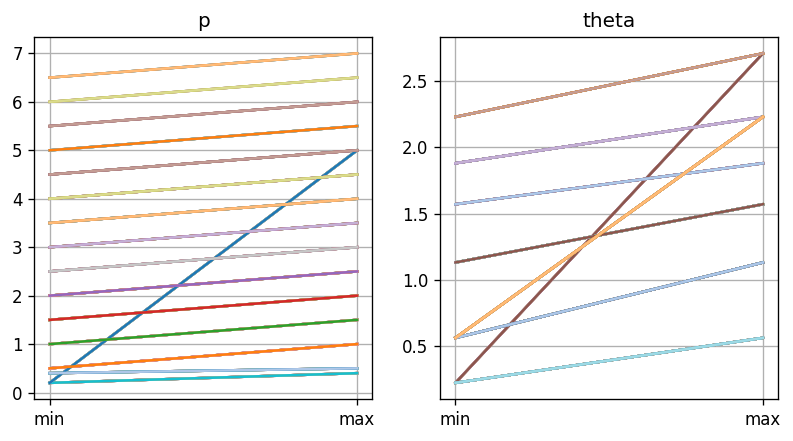

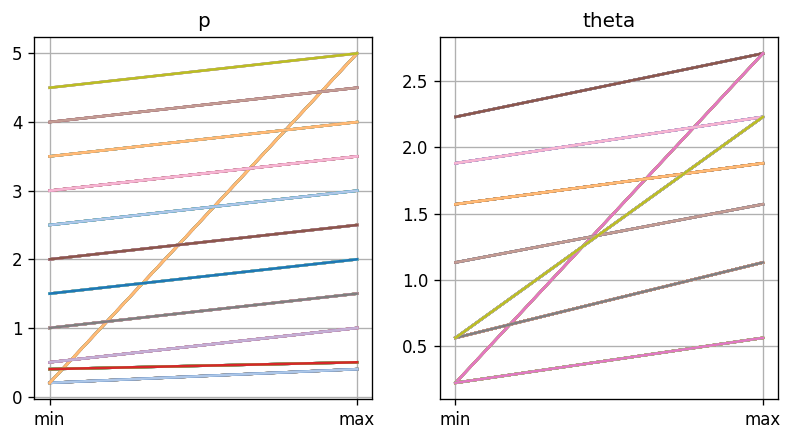

In [10]:
fig, axs = plt.subplots(1,2, figsize=(8, 4), dpi=120)
axs[0].plot(efficiency_e_table[['p_min', 'p_max']].values.T);
axs[1].plot(efficiency_e_table[['theta_min', 'theta_max']].values.T);
axs[0].set_xticks([0,1], ['min', 'max'])
axs[1].set_xticks([0,1], ['min', 'max'])
axs[0].set_title('p')
axs[1].set_title('theta')
axs[0].grid()
axs[1].grid();

fig, axs = plt.subplots(1,2, figsize=(8, 4), dpi=120)
axs[0].plot(pi_e_fake_table[['p_min', 'p_max']].values.T);
axs[1].plot(pi_e_fake_table[['theta_min', 'theta_max']].values.T);
axs[0].set_xticks([0,1], ['min', 'max'])
axs[1].set_xticks([0,1], ['min', 'max'])
axs[0].set_title('p')
axs[1].set_title('theta')
axs[0].grid()
axs[1].grid();

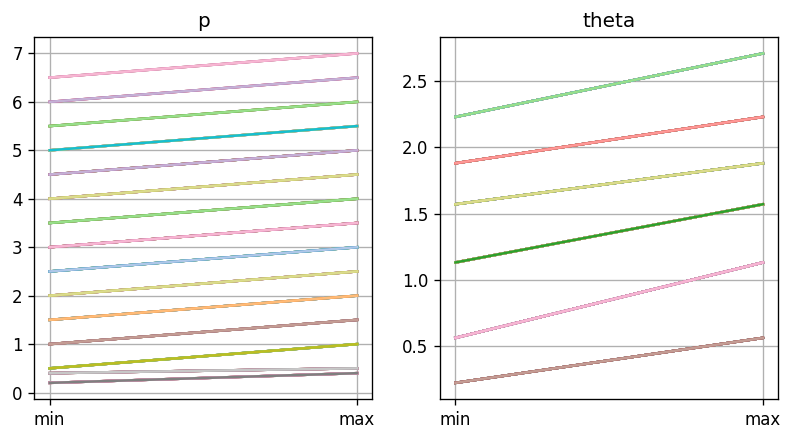

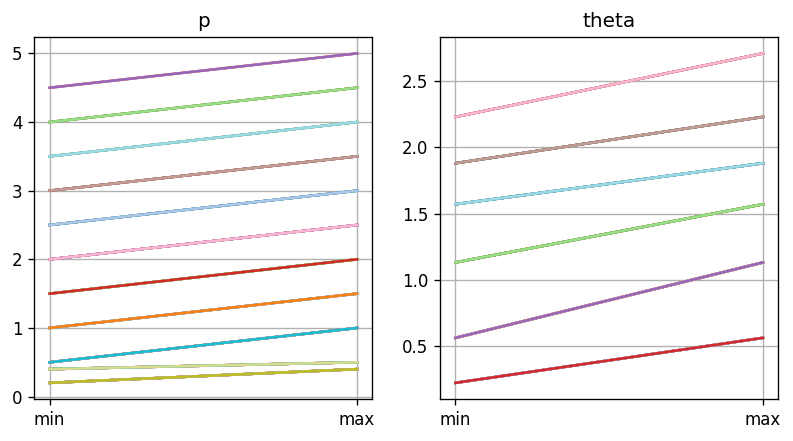

In [11]:
exclude_e_bins_query = "not (p_min == 0.2 and p_max == 5.0) "
exclude_e_bins_query += "and not (theta_min == 0.22 and theta_max == 2.71) "
exclude_e_bins_query += "and not (theta_min == 0.56 and theta_max == 2.23)"

efficiency_e_table = efficiency_e_table.query(exclude_e_bins_query)
pi_e_fake_table = pi_e_fake_table.query(exclude_e_bins_query)

fig, axs = plt.subplots(1,2, figsize=(8, 4), dpi=120)
axs[0].plot(efficiency_e_table[['p_min', 'p_max']].values.T);
axs[1].plot(efficiency_e_table[['theta_min', 'theta_max']].values.T);
axs[0].set_xticks([0,1], ['min', 'max'])
axs[1].set_xticks([0,1], ['min', 'max'])
axs[0].set_title('p')
axs[1].set_title('theta')
axs[0].grid()
axs[1].grid();

fig, axs = plt.subplots(1,2, figsize=(8, 4), dpi=120)
axs[0].plot(pi_e_fake_table[['p_min', 'p_max']].values.T);
axs[1].plot(pi_e_fake_table[['theta_min', 'theta_max']].values.T);
axs[0].set_xticks([0,1], ['min', 'max'])
axs[1].set_xticks([0,1], ['min', 'max'])
axs[0].set_title('p')
axs[1].set_title('theta')
axs[0].grid()
axs[1].grid();

In [17]:
efficiency_e_table.query('0.1<p_max<=1')[['p_min', 'p_max', 'theta_min', 'theta_max', 'charge']].value_counts()

p_min  p_max  theta_min  theta_max  charge
0.2    0.4    0.56       1.13       +         1
0.5    1.0    0.56       1.13       -         1
0.4    0.5    1.88       2.23       -         1
              2.23       2.71       +         1
                                    -         1
0.5    1.0    0.22       0.56       +         1
                                    -         1
              0.56       1.13       +         1
              1.13       1.57       +         1
0.2    0.4    0.56       1.13       -         1
0.5    1.0    1.13       1.57       -         1
              1.57       1.88       +         1
                                    -         1
              1.88       2.23       +         1
                                    -         1
              2.23       2.71       +         1
0.4    0.5    1.88       2.23       +         1
              1.57       1.88       -         1
                                    +         1
              1.13       1.57       -        

In [18]:
pi_e_fake_table[['p_min', 'p_max', 'theta_min', 'theta_max', 'charge']].value_counts()

p_min  p_max  theta_min  theta_max  charge
0.2    0.4    0.22       0.56       +         1
2.0    2.5    1.88       2.23       -         1
2.5    3.0    1.88       2.23       +         1
              1.57       1.88       -         1
                                    +         1
                                             ..
0.5    1.0    1.88       2.23       -         1
                                    +         1
              1.57       1.88       -         1
                                    +         1
4.5    5.0    0.56       1.13       -         1
Name: count, Length: 109, dtype: int64

## Hadron corrections

In [18]:
sys_path = '/group/belle2/dataprod/Systematics/systematic_corrections_framework/scripts/'

sys.path.insert(1, sys_path)

import os
import efficiency_table as et
import weight_table as wm
import process_tables as pt
import show_db_content as sdb
import show_variables as sv
import show_collections as sc
from IPython.display import HTML

In [8]:
var_table = sv.show_ntuple_variables(particle_type='K', data_query=["MC15ri_1"], type='html')
HTML(var_table)

,Global PIDs,PID BDTs,CMS Frame,Detector hits,PID log(Likelihood),Track Isolation,Uncategorized
0,deuteronID,pidChargedBDTScore_mu,phiCMS,nSVDHits,pidLogLikelihoodOf2212FromTOP,minET2ETIsoScore,firstCDCLayer
1,electronID_noSVD_noTOP,pidPairChargedBDTScore_mu_pi,cosThetaCMS,nPXDHits,pidLogLikelihoodOf13FromCDC,,pz
2,pionIDNN,pidChargedBDTScore_pi,pzCMS,nCDCHits,pidLogLikelihoodOf321FromSVD,,mcPDG
3,pionID,pidChargedBDTScore_K,pCMS,,pidLogLikelihoodOf13FromTOP,,clusterE9E21
4,kaonIDNN,pidChargedBDTScore_e,ECMS,,pidLogLikelihoodOf2212FromSVD,,phi
5,protonID,pidPairChargedBDTScore_e_pi,thetaCMS,,pidLogLikelihoodOf11FromKLM,,mcErrors
6,kaonID,pidChargedBDTScore_p,pyCMS,,pidLogLikelihoodOf211FromARICH,,clusterEoP
7,electronID,,pxCMS,,pidLogLikelihoodOf211FromECL,,clusterE
8,electronID_noSVD,,ptCMS,,pidLogLikelihoodOf1000010020FromCDC,,clusterAbsZernikeMoment51
9,muonID,,,,pidLogLikelihoodOf11FromSVD,,clusterLAT


In [ ]:
ratio_cfg = {
    "cut": "kaonID > 0.9",
    "particle_type": "K",
    "data_collection": "proc13+prompt",
    "mc_collection": "MC15ri",
    "track_variables": ["p", "cosTheta", "charge"],
    "precut": "",
    "binning": [np.linspace(0.2, 4, 11),
               [-0.866, -0.682, -0.4226, -0.1045, 0.225, 0.5, 0.766, 0.8829, 0.9563],
               [-2, 0, 2]]
}
efficiency_obj = wm.produce_data_mc_ratio(**ratio_cfg)
efficiency_obj.plot()

In [ ]:
efficiency_K_table = efficiency_obj.create_weights()
efficiency_K_table

In [ ]:
os.makedirs('tables/', exist_ok=True)
efficiency_K_table.to_csv('tables/k_efficiency.csv', index=None)

In [19]:
# To load the CSV table:
efficiency_K_table = pd.read_csv('tables/k_efficiency.csv', index_col=None)

In [ ]:
ratio_cfg = {
    "cut": "kaonID > 0.9",
    "particle_type": "pi",
    "data_collection": "proc13+prompt",
    "mc_collection": "MC15ri",
    "track_variables": ["p", "cosTheta", "charge"],
    "precut": "",
    "binning": [np.linspace(0.2, 4, 11),
               [-0.866, -0.682, -0.4226, -0.1045, 0.225, 0.5, 0.766, 0.8829, 0.9563],
               [-2, 0, 2]]
}
pi_K_fake_obj = wm.produce_data_mc_ratio(**ratio_cfg)
pi_K_fake_obj.plot()

In [ ]:
pi_K_fake_table = pi_K_fake_obj.create_weights()
pi_K_fake_table.to_csv('tables/pi_K_fake.csv', index=None)

In [20]:
# To load the CSV table:
pi_K_fake_table = pd.read_csv('tables/pi_K_fake.csv', index_col=None)

## Apply corrections

In [21]:
import warnings
from sysvar import add_weights_to_dataframe

e_tables = {(11, 11): efficiency_e_table,
            (11, 211): pi_e_fake_table
}
e_thresholds = {11: ('pidChargedBDTScore_e', 0.9)}

Welcome to JupyROOT 6.26/14


In [22]:
K_charge_mapping = {1: 321, -1: -321}
pi_charge_mapping = {1: 211, -1: -211}
# Creating the new column using map
df_bestSelected_mc['D_K_PDG'] = df_bestSelected_mc['D_K_charge'].map(K_charge_mapping)
df_bestSelected_mc['D_pi1_PDG'] = df_bestSelected_mc['D_pi1_charge'].map(pi_charge_mapping)
df_bestSelected_mc['D_pi2_PDG'] = df_bestSelected_mc['D_pi2_charge'].map(pi_charge_mapping)
df_bestSelected_mc = df_bestSelected_mc.reset_index() # for a bug in add_weights_to_dataframe

In [23]:
df_bestSelected_mc[['D_K_PDG','D_K_charge','D_pi1_PDG','D_pi1_charge']].value_counts()

D_K_PDG  D_K_charge  D_pi1_PDG  D_pi1_charge
-321     -1.0         211        1.0            24633
 321      1.0        -211       -1.0            22494
Name: count, dtype: int64

Required variables: ['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 87.8%


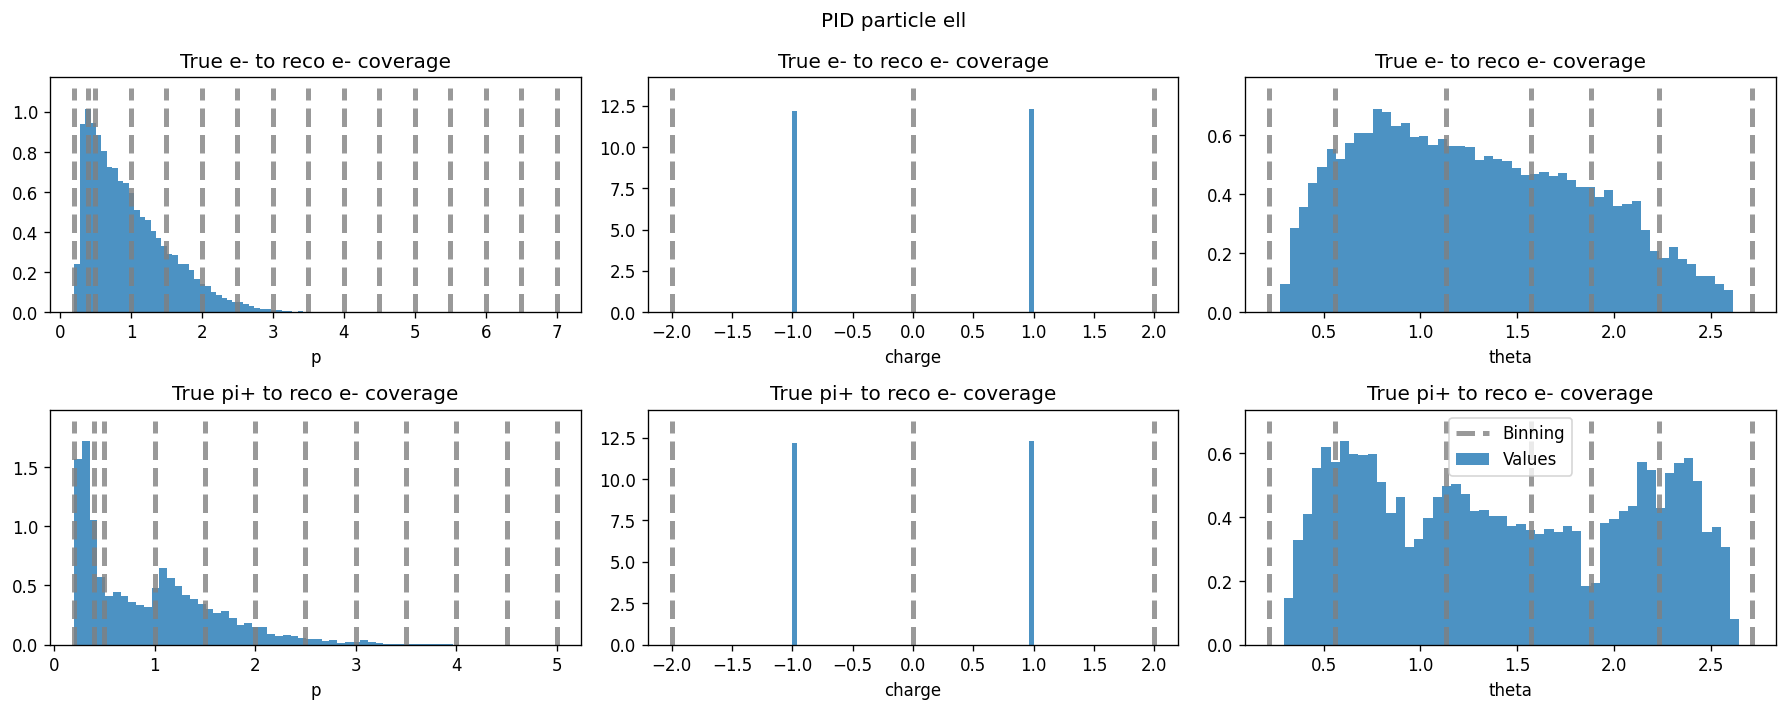

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    add_weights_to_dataframe('ell',
                             df_bestSelected_mc,
                             systematic='custom_PID',
                             custom_tables=e_tables,
                             custom_thresholds=e_thresholds,
                             show_plots=True,
                             sys_seed=0)

In [ ]:
df_bestSelected_mc[['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']].isna().sum()

In [25]:
df_bestSelected_mc.query('ell_Weight==1')[['ell_Weight'] + [f'ell_Weight_{i}' for i in range(100)]]

,ell_Weight,ell_Weight_0,ell_Weight_1,ell_Weight_2,ell_Weight_3,ell_Weight_4,ell_Weight_5,ell_Weight_6,ell_Weight_7,ell_Weight_8,...,ell_Weight_90,ell_Weight_91,ell_Weight_92,ell_Weight_93,ell_Weight_94,ell_Weight_95,ell_Weight_96,ell_Weight_97,ell_Weight_98,ell_Weight_99
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
15,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
32,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47113,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
47117,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
47120,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
47121,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
k_tables = {(321, 321): efficiency_K_table,
            (321, 211): pi_K_fake_table}
k_thresholds = {321: ('kaonID', 0.9)}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    add_weights_to_dataframe('D_K',
                             df_bestSelected_mc,
                             systematic='custom_PID',
                             custom_tables=k_tables,
                             custom_thresholds=k_thresholds,
                             show_plots=True)

In [ ]:
df_bestSelected_mc.query('D_K_Weight==1')[['D_K_Weight'] + [f'D_K_Weight_{i}' for i in range(100)]]

In [ ]:
df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc[['ell_Weight', 'D_K_Weight']].product(axis=1)

In [30]:
df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc['ell_Weight']

/tmp/ipykernel_53098/3500322995.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc['ell_Weight']


In [31]:
samples=util.get_dataframe_samples_new(df_bestSelected_mc, 'e', template=False)
mpl=util.mpl(samples,df_bestSelected_data)

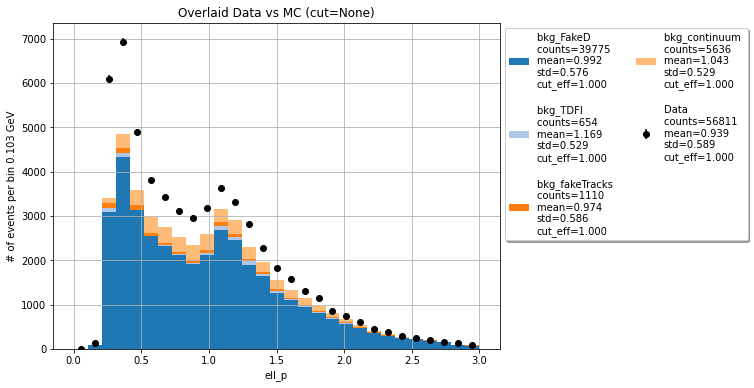

In [32]:
b1 = np.linspace(0,3,30)
mpl.plot_data_mc_overlaid(variable='ell_p',bins=b1,cut=None,scale=[1, 42/50],correction=True)

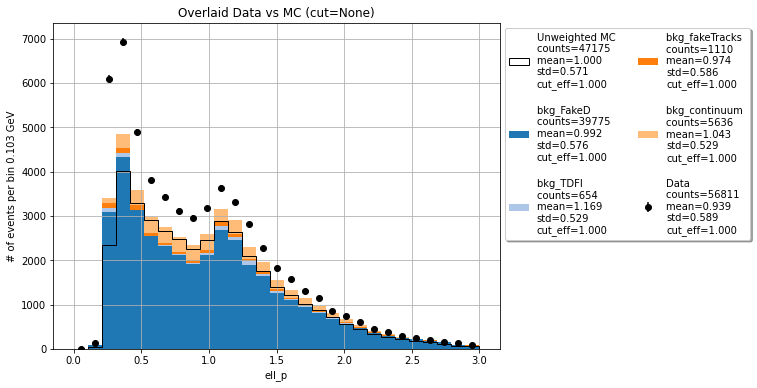

In [37]:
b1 = np.linspace(0,3,30)
mpl.plot_data_mc_overlaid(variable='ell_p',bins=b1,cut=None,scale=[1, 42/50],correction=True)

In [ ]:
plt.hist2d(x=df_bestSelected_ccbar['signal_prob'],
           y=df_bestSelected_ccbar['continuum_prob'],
           bins=[20,20])
plt.title('ccbar')
plt.xlabel('signal prob')
plt.ylabel('continuum prob');

In [ ]:
plt.hist2d(x=df_bestSelected_data['signal_prob'],
           y=df_bestSelected_data['continuum_prob'],
           bins=[20,20])
plt.title('data')
plt.xlabel('signal prob')
plt.ylabel('continuum prob');

In [ ]:
plt.hist2d(x=df_bestSelected_sig['signal_prob'],
           y=df_bestSelected_sig['continuum_prob'],
           bins=[20,20])
plt.title('sig')
plt.xlabel('signal prob')
plt.ylabel('continuum prob');

In [ ]:
b2 = np.linspace(0,5,50)
plot_continuum_overlaid(variable='p_D_l',bins=b2,scale=[1/15.2,1,1],cut='signal_prob<0.3 and continuum_prob>0.8')

In [ ]:
# Check for duplicate entries
util.check_duplicate_entries(samples)